# Explore Feature Selection Techniques

After loading the dataset and apply the Feature Engineering, Feature Selection is used to extract the more suitable feature combination for the model we are going to use. That is why exploring different techniques would be useful to get the best combination for increase the performance of our model. Some of the more common FS methods are explored here.

The steps followed in this script are:
1. [Load data](#1-load-data)
2. [Data cleasing and feature engineering](#2-data-cleasing-and-feature-engineering)
3. [Feature Selection](#3-feature-selection)
    - [Filter methods](#31-filter-methods)
    - [Wrapped methods](#32-wrapper-methods)
    - [Embbeded methods](#33-embbeded-methods)

## Load packages

In [1]:
# Change Git path
import os 
CURRENT_PATH = os.getcwd()
os.chdir(CURRENT_PATH.split('Feature-engineering-with-TF',1)[0] + 'Feature-engineering-with-TF/03-FeatureSelection')
from utils_fs import *

# for data processing and manipulation
import pandas as pd

# scikit-learn modules for feature selection and model evaluation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Omit warning messages from the following code
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 1. Load data

The description and the dowloading code for the current dataset is explained in [README.md](https://github.com/saraalgo/Feature-engineering-with-TF/blob/main/README.md).

Load the raw data from */exdata* folder. In this case, the selected problem **Alcohol Effects On Study** has two main files: **Portuguese** and **Math**. The first step is to concatenate them to have a bigger dataset before starting.

In [2]:
# Read CSV files as dataframe
df_maths = pd.read_csv('../exdata/Alcohol-effects-study/Maths.csv', header=0)
df_port = pd.read_csv('../exdata/Alcohol-effects-study/Portuguese.csv', header=0)

# Adding them an extra column with the name of the subject and check that both have the same columns
df_maths.insert(0, 'Subject', 'Maths')
df_port.insert(0, 'Subject', 'Portuguese')

print(f'Both dataframes have the same column names: {df_maths.columns.equals(df_port.columns)}')

# Concatenate and print dataset
df = pd.concat([df_maths, df_port], ignore_index=True)
df.head()

Both dataframes have the same column names: True


,Subject,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,Maths,GP,F,18,U,GT3,A,4,4,at_home,...,4,3,4,1,1,3,6,5,6,6
1,Maths,GP,F,17,U,GT3,T,1,1,at_home,...,5,3,3,1,1,3,4,5,5,6
2,Maths,GP,F,15,U,LE3,T,1,1,at_home,...,4,3,2,2,3,3,10,7,8,10
3,Maths,GP,F,15,U,GT3,T,4,2,health,...,3,2,2,1,1,5,2,15,14,15
4,Maths,GP,F,16,U,GT3,T,3,3,other,...,4,3,2,1,2,5,4,6,10,10


## 2. Data cleasing and feature engineering

In [3]:
# Check and remove rows with NaN values
print(f'Before it was {df.isnull().sum().sum()} NaN values')
df.dropna(how='all')
print(f'After the dropping there are {df.isnull().sum().sum()} NaN values')

Before it was 0 NaN values
After the dropping there are 0 NaN values


A Feature engineering with **sklearn** is applied, for categorical columns with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and for numerical ones with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). In the function **FE_transform** inside [*utils_fs.py*](https://github.com/saraalgo/Feature-engineering-with-TF/blob/main/03-FeatureSelection/utils_fs.py) is defined the Pipeline of our model to train it with [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), along with the meant FE.

In [4]:
# Divide input and output data
df["output"] = df["G3"].copy()
data = df.drop("G3", axis = 1)

X = data.drop('output', axis = 1)
Y = data.output

In [5]:
# Feature engineering
X_tranform = FE_tranform(X)
X_tranform

array([[ 1.02788947,  1.24207744,  1.46630216, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22103488, -1.42608891, -1.26243127, ...,  1.        ,
         1.        ,  0.        ],
       [-1.3926743 , -1.42608891, -1.26243127, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 1.02788947, -1.42608891, -1.26243127, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22103488,  0.35268866, -1.26243127, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.02788947,  0.35268866, -0.35285346, ...,  1.        ,
         1.        ,  0.        ]])

## 3. Feature Selection

In [6]:
# Baseline model with all features
all_features_eval_df = evaluate_model_on_features(X_tranform, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df
results.head()

,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.22306,0.860096,60


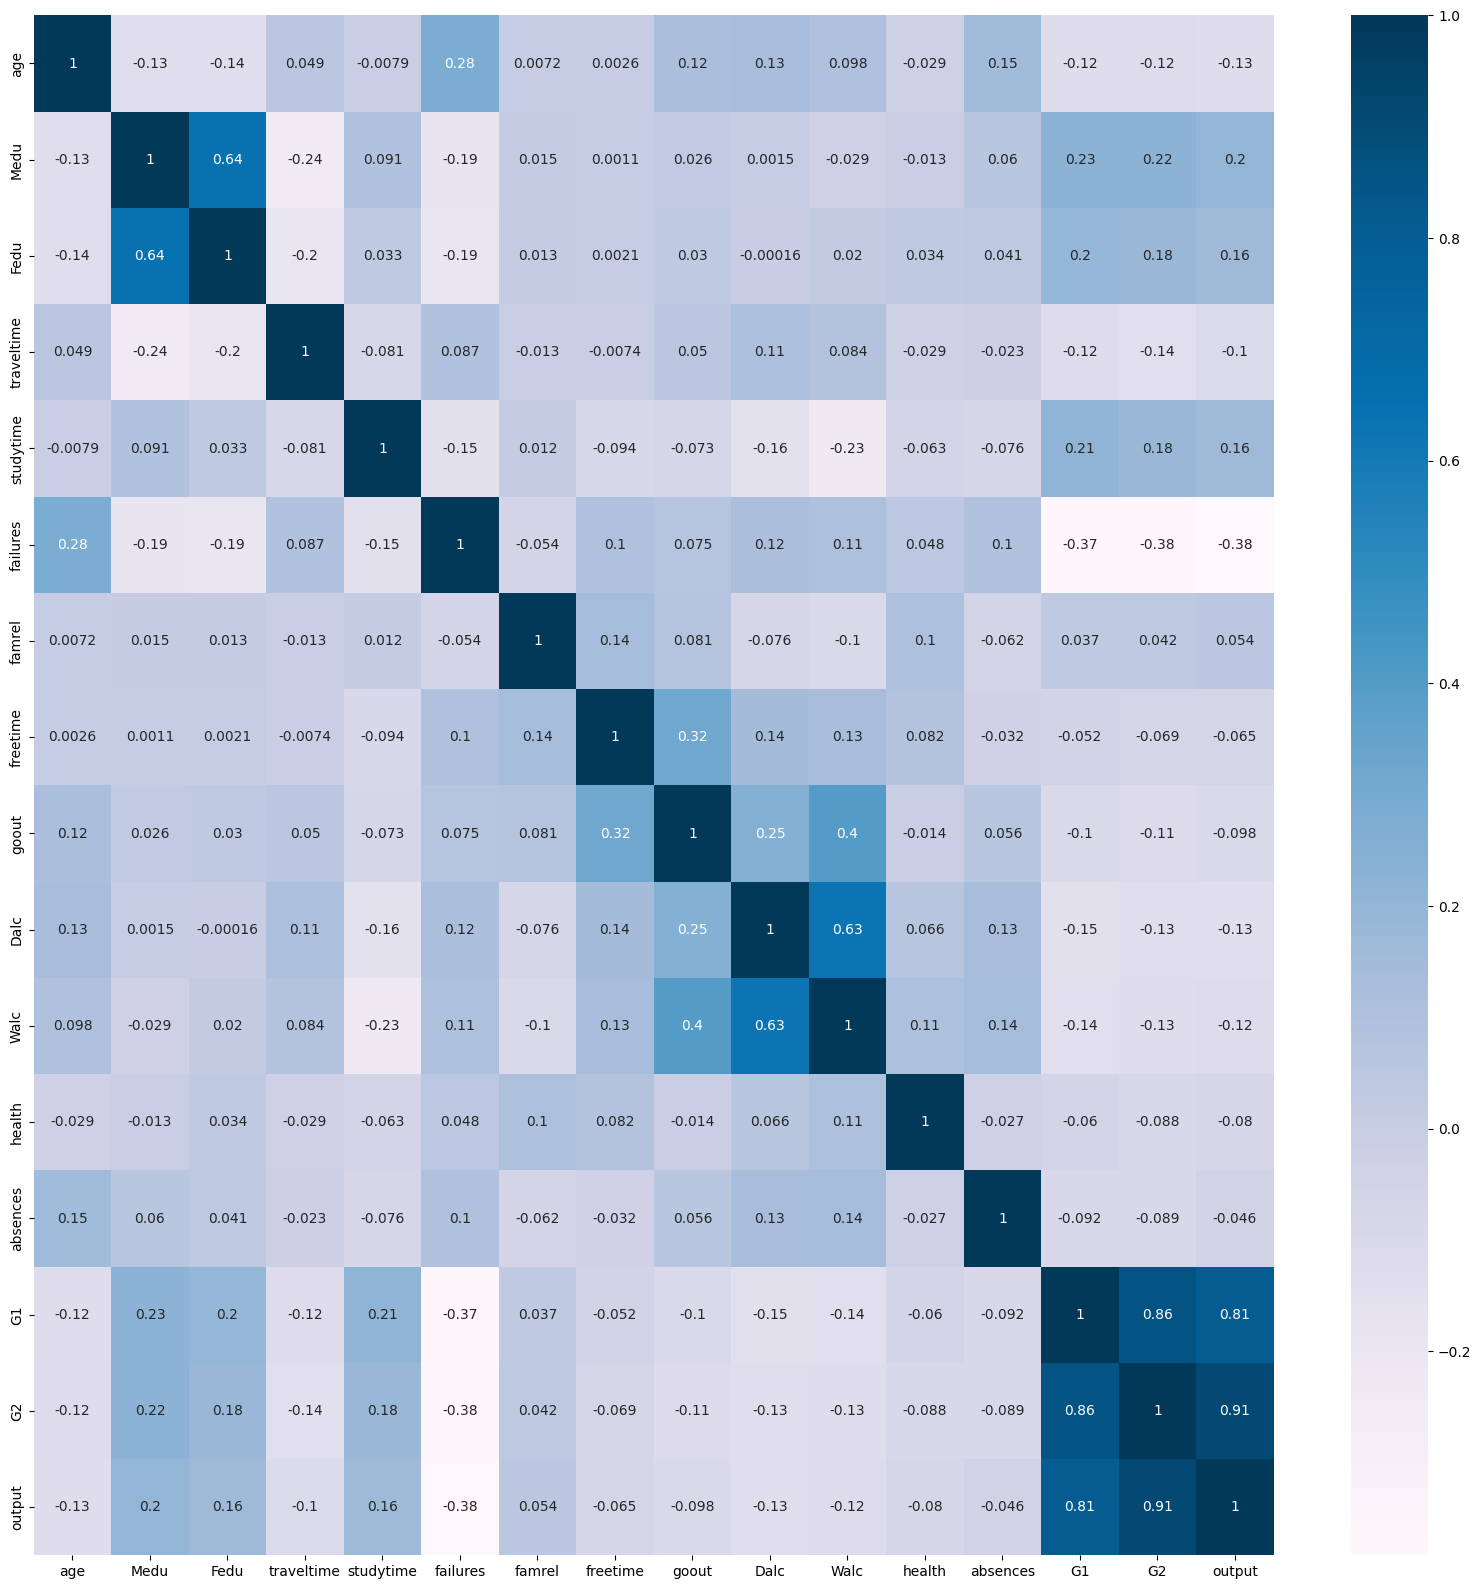

In [7]:
# Check correlation matrix to see if there are highly correlated numerical features
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = data.corr() 

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

### 3.1 Filter methods

This type of feature selection uses statistical methods to rank a given set of features. Moreover, it does this ranking regardless of the model you will be training on (i.e. you only need the feature values). When using these, it is important to note the types of features and target variable you have. 

#### Correlation with output (remove <0.2 and >0.9)

In [8]:
cor_target = abs(cor["output"])

# Select highly correlated features with output (threshold = 0.2)
relevant_features = cor_target[cor_target<0.2]
redundant_features = cor_target[cor_target>0.9]
names_remove_1 = [index for index, value in relevant_features.iteritems()]
names_remove_2 = [index for index, value in relevant_features.iteritems()]
names_remove = names_remove_1 + names_remove_2

# Display the results
print(f'The numerical features NOT strong corr or TOO MUCH corr with the output feature are: {names_remove}')
col_names = list(data.columns)
col_names.remove('output')
col_names = list(set(col_names) - set(names_remove))

X_corr = FE_tranform(X[col_names])
# Evaluate the model with new features
corr_features = evaluate_model_on_features(X_corr, Y)
corr_features.index = ['Corr >0.2 and <0.9']

# Append to results and display
results = results.append(corr_features)
results.head()


The numerical features NOT strong corr or TOO MUCH corr with the output feature are: ['age', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'age', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.223060,0.860096,60
Corr >0.2 and <0.9,2.009011,1.417396,0.980766,49


#### Univariate Selection - SelectKBest with F-Statistic

In [9]:
select = SelectKBest(score_func=f_regression, k=20)
best_20 = select.fit_transform(X_tranform,Y)
 
print("After selecting best 20 features:", best_20.shape)

# Evaluate the model with 20 best features
f_features = evaluate_model_on_features(best_20, Y)
f_features.index = ['F-statistic for 20']

# Append to results and display
results = results.append(f_features)
results.head()

After selecting best 20 features: (1044, 20)


,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.223060,0.860096,60
Corr >0.2 and <0.9,2.009011,1.417396,0.980766,49
F-statistic for 20,2.013795,1.419083,0.959904,20


### 3.2 Wrapper methods

Wrapper methods use a model to measure the effectiveness of a particular subset of features. One approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). 

#### Recursive Feature Elimination - 20 features

In [10]:
rfe_filter = run_rfe(X, Y)
rfe_filter


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [11]:
# Evaluate the model with RFE 20
X_tranform_df = pd.DataFrame(X_tranform)
rfe_features = evaluate_model_on_features(X_tranform_df.loc[:, rfe_filter], Y)
rfe_features.index = ['RFE wrapper']

# Append to results and display
results = results.append(rfe_features)
results.head(n=10)

,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.223060,0.860096,60
Corr >0.2 and <0.9,2.009011,1.417396,0.980766,49
F-statistic for 20,2.013795,1.419083,0.959904,20
RFE wrapper,1.571079,1.253427,0.875215,20


### 3.3 Embbeded methods

Some models already have intrinsic properties that select the best features when it is constructed. With that, it is simply to access these properties to get the scores for each feature.

#### Feature Importance

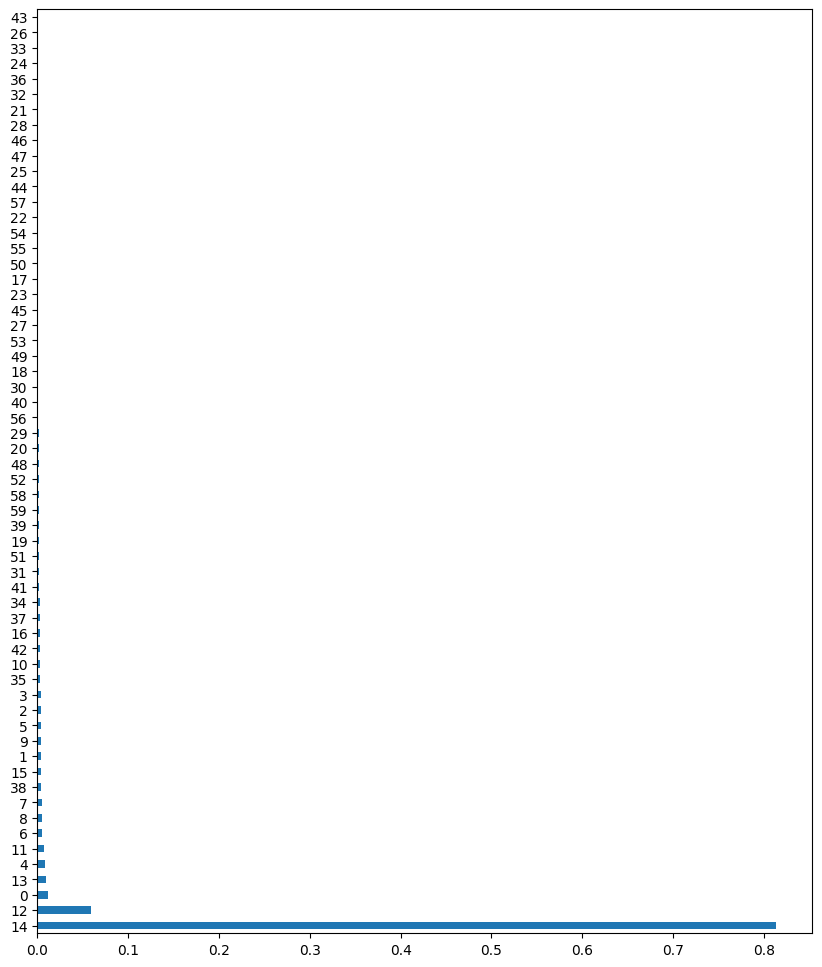

In [12]:
# Train model
X_tranform_df = pd.DataFrame(X_tranform)
X_train, X_test, Y_train, Y_test = train_test_split(X_tranform, Y, test_size = 0.2, random_state = 1995)
model = fit_model(X_train, Y_train)

# Plot feature importance
plt.figure(figsize=(10, 12))
feat_importances = pd.Series(model.feature_importances_, index=X_tranform_df.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [13]:
# Filter of column based of feature importance
model = SelectFromModel(model, prefit=True, threshold=0.013)
fi_filter = model.get_support()
fi_filter

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [14]:
# Calculate and check model metrics
fi_features = evaluate_model_on_features(X_tranform_df.loc[:, fi_filter], Y)
fi_features.index = ['Feature Importance']

# Append to results and display
results = results.append(fi_features)
results.head(n=10)

,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.223060,0.860096,60
Corr >0.2 and <0.9,2.009011,1.417396,0.980766,49
F-statistic for 20,2.013795,1.419083,0.959904,20
RFE wrapper,1.571079,1.253427,0.875215,20
Feature Importance,1.483263,1.217893,0.837672,2


#### L1 Regularization

In [15]:
# Train with LSV or Lasso Regulartization
# Train model
X_tranform_df = pd.DataFrame(X_tranform)
X_train, X_test, Y_train, Y_test = train_test_split(X_tranform, Y, test_size = 0.2, random_state = 1995)

# Select L1 regulated features from LinearSVC output 
selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
selection.fit(X_train, Y_train)
l1_filter = selection.get_support()
l1_filter

c:\Users\Sara\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [16]:
# Calculate and check model metrics
l1_features = evaluate_model_on_features(X_tranform_df.loc[:, l1_filter], Y)
l1_features.index = ['L1 Reg']

# Append to results and display
results = results.append(l1_features)
results

,MSE,RMSE,MAE,Feature Count
All features,1.495875,1.223060,0.860096,60
Corr >0.2 and <0.9,2.009011,1.417396,0.980766,49
F-statistic for 20,2.013795,1.419083,0.959904,20
RFE wrapper,1.571079,1.253427,0.875215,20
Feature Importance,1.483263,1.217893,0.837672,2
L1 Reg,1.495875,1.223060,0.860096,60
